In [0]:
from google.colab import drive
import os
import numpy as np
import pandas as pd
import pickle
from tqdm import tqdm
import cv2
from google.colab.patches import cv2_imshow # because cv2.imshow does'nt work in colab
from matplotlib import pyplot as plt
import random
import numpy as np
from numpy import linalg as LA
# from extract_cnn_vgg16_keras import VGGNet
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input


In [0]:
def mountDir(dir, subdir = '', path = 'drive/My Drive/'):
  
    drive.mount('/content/drive')
    print(os.getcwd())
    if subdir == '':
        os.chdir(path + dir)
    else:
        os.chdir(path + dir + '/' + subdir)
    print(os.getcwd())

In [0]:
mountDir('BDMH Project')

In [0]:
# !unzip brain-mri-images-for-brain-tumor-detection.zip
# /content/drive/My Drive/BDMH Project/brain-mri-images-for-brain-tumor-detection.zip

In [0]:
def build_paths(title):
    paths = []
    for (dirpath, dirnames, filenames) in tqdm(os.walk(str(os.getcwd())+'/'+title+'/')):
        for i in filenames:
            paths.append(str(dirpath)+i)
    return paths

In [0]:
negative_images = build_paths('no')
positive_images = build_paths('yes')

1it [00:00, 319.40it/s]
1it [00:00, 281.80it/s]


In [0]:
#Making the training and testing dataset
pos_train = random.sample(positive_images, 100)
neg_train = random.sample(negative_images, 60)
pos_test = [item for item in positive_images if item not in pos_train]
neg_test = [item for item in negative_images if item not in neg_train]



*   **Preprocessing**



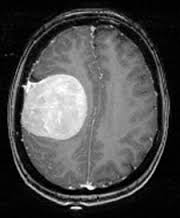

In [0]:
cv2_imshow(cv2.imread(positive_images[0]))

In [0]:
cv2.imread(negative_images[0]).shape

(630, 630, 3)

In [0]:
cv2.imread(positive_images[0]).shape

(218, 180, 3)

In [0]:
#Preprocessing
#cropping the images
def preprocess(image_data):
  set_new = []
  for i in image_data:
    

    img =cv2.imread(i)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    add_pixels_value=0
    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    ADD_PIXELS = add_pixels_value
    new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
    set_new.append(new_img)
  return set_new

In [0]:
pos_crop_images = preprocess(np.array(pos_train))
neg_crop_images = preprocess(np.array(neg_train))
pos_crop_images_test = preprocess(np.array(pos_test))
neg_crop_images_test = preprocess(np.array(neg_test))

In [0]:
#Saving the cropped images to drive
for i in range(len(pos_crop_images_test)):
  io.imsave('/content/drive/My Drive/BDMH Project/pos_crop_test/'+str(i)+'_bb.png',pos_crop_images_test[i])
for i in range(len(neg_crop_images_test)):
  io.imsave('/content/drive/My Drive/BDMH Project/neg_crop_test/'+str(i)+'_bb.png',neg_crop_images_test[i])



*   ***Data Augmentation***




In [0]:
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True
)

In [0]:
negative_aug_images = build_paths('new_neg2_aug')
positive_aug_images = build_paths('new_pos2_aug')
new_negative_images = neg_train+negative_aug_images
new_positive_images = pos_train+positive_aug_images

In [0]:
def storeData(data, filename, ext = '.pkl'):

    pickle.dump(data, open(filename + ext, 'wb') )  
    print(filename + ext + ' saved!')

In [0]:
storeData(data,'train_data')
storeData(label,'train_label')
storeData(data_test,'test_data')
storeData(label_test,'test_label')



*   ***VGG16 Model For feature Extraction***




In [0]:

class VGGNet:
    def __init__(self):
        # weights: 'imagenet'
        # pooling: 'max' or 'avg'
        # input_shape: (width, height, 3), width and height should >= 48
        self.input_shape = (102, 136, 3)
        self.weight = 'imagenet'
        self.pooling = 'max'
        self.model = VGG16(weights = self.weight, input_shape = (self.input_shape[0], self.input_shape[1], self.input_shape[2]), pooling = self.pooling, include_top = False)
        self.model.predict(np.zeros((1, 102, 136 , 3)))

    '''
    Use vgg16 model to extract features
    Output normalized feature vector
    '''
    def extract_feat(self, img_path):
        # img=cv2.imread(img_path)
        img = image.load_img(img_path, target_size=(self.input_shape[0], self.input_shape[1]))
        img = image.img_to_array(img)
        # img=img.resize(224,224)
        img = np.expand_dims(img, axis=0)
        img = preprocess_input(img)
        feat = self.model.predict(img)
        norm_feat = feat[0]/LA.norm(feat[0])
        return norm_feat

In [0]:
model=VGGNet()

In [0]:
def feature_extraction(path):

  print("####features extraction process begins ####")
  features=[]
  for i in tqdm(range(len(path))):
    print(path[i])
    queryFeat = model.extract_feat(path[i])
    features.append(queryFeat)

  print("####features created ####")
  return features
  

In [0]:
#returns the features as data and labels as label
def create_dataframe(neg_path,pos_path):
  neg_features = feature_extraction(neg_path)
  pos_features = feature_extraction(pos_path)
  ng = pd.DataFrame(neg_features)
  ps = pd.DataFrame(pos_features)
  data = pd.concat([ng,ps])
  ng_label = np.zeros(len(neg_features))
  pos_label = np.ones(len(pos_features))
  label = pd.concat([pd.DataFrame(ng_label),pd.DataFrame(pos_label)])
  return data,label



In [0]:
data,label = create_dataframe(new_negative_images,new_positive_images)
data_test,label_test = create_dataframe(build_paths('neg_crop_test'),build_paths('pos_crop_test'))



*   ***Performance Comparison of standard classifiers***




In [155]:
!pip install catboost

     |████████████████████████████████| 64.7MB 61kB/s 


In [0]:
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.svm import NuSVC
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
import lightgbm as lgbm

LR: 0.868513 (0.034675)
XgBoost: 0.882051 (0.029147)
KNN: 0.904821 (0.039725)
CatBoost: 0.912821 (0.033190)
LGBM: 0.911179 (0.028175)
NuSVM: 0.882667 (0.032268)
SVM: 0.914462 (0.030842)


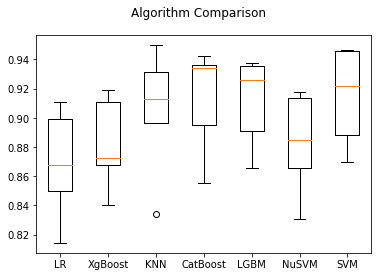

In [0]:

models = []
models.append(('LR', LogisticRegression()))
models.append(('XgBoost', XGBClassifier()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CatBoost', CatBoostClassifier(verbose=0)))
models.append(('LGBM',lgbm.LGBMClassifier(objective='binary')))
# compile the keras model
models.append(('NuSVM', NuSVC(kernel = 'poly',gamma =10,nu=0.5)))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
X= np.array(data)
Y=[int(i) for i in np.array(label[0])]
for name, model in models:
	skf = StratifiedKFold(n_splits=5)
	cv_results = model_selection.cross_val_score(model, X, Y, cv=skf, scoring=scoring)
	results.append(cv_results)
	names.append(name)
	msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
	print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [0]:
from sklearn.svm import SVC
model = NuSVC(kernel = 'poly',gamma =10,nu=0.5)
skf = StratifiedKFold(n_splits=5)
print(cross_val_score(model, X, Y, cv=skf, scoring='accuracy'))
	

In [0]:
print(cross_val_score(model, X, Y, cv=skf, scoring='roc_auc'))

[0.94218353 0.93344001 0.97860322 0.98399395 0.98778451]


In [0]:

from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, Y,
#                                                     stratify=Y, 
#                                                     test_size=0.4)

In [0]:
def loadData(filename, ext = '.pkl'):     

    filename += ext
    data = pickle.load(open(filename, 'rb'))  
    print(filename, ' loaded!')
    
    return data

In [0]:
data = loadData('train_data')
label = loadData('train_label')
data_test = loadData('test_data')
label_test = loadData('test_label')

train_data.pkl  loaded!
train_label.pkl  loaded!
test_data.pkl  loaded!
test_label.pkl  loaded!


In [191]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
X_train= np.array(data)
Y_train=[int(i) for i in np.array(label[0])]
clf = NuSVC(kernel = 'poly',gamma =10,nu=0.5)
clf.fit(X_train, Y_train)



NuSVC(break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
      decision_function_shape='ovr', degree=3, gamma=10, kernel='poly',
      max_iter=-1, nu=0.5, probability=False, random_state=None, shrinking=True,
      tol=0.001, verbose=False)

In [0]:
X_test= np.array(data_test)
Y_test=[int(i) for i in np.array(label_test[0])]

In [0]:
y_pred_nusvc = clf.predict(X_test)

In [0]:
def accuracy(y_pred,Y_test):
  a=0
  for i in range(len(y_pred)):
    if y_pred[i]==Y_test[i]:
      a=a+1
  
  return a/len(y_pred)



In [193]:
accuracy(y_pred_nusvc,Y_test)

0.8279569892473119

[[30  8]
 [ 6 49]]


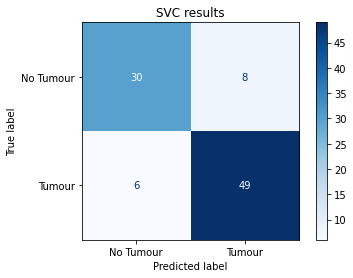

In [186]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(clf, X_test, Y_test,
                                 display_labels=['No Tumour','Tumour'],
                                 cmap=plt.cm.Blues,
                                 normalize=None)
disp.ax_.set_title('SVC results')

# print(title)
print(disp.confusion_matrix)

plt.show()


In [175]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='adam', alpha=1e-5,activation = 'relu', hidden_layer_sizes=(500, 150),verbose=True)
clf.fit(X_train, Y_train)
y_pred = clf.predict(X_test)

Iteration 1, loss = 0.60815201
Iteration 2, loss = 0.38716935
Iteration 3, loss = 0.26512900
Iteration 4, loss = 0.19239052
Iteration 5, loss = 0.14715629
Iteration 6, loss = 0.11108903
Iteration 7, loss = 0.09100539
Iteration 8, loss = 0.06780821
Iteration 9, loss = 0.05201297
Iteration 10, loss = 0.04087013
Iteration 11, loss = 0.02953517
Iteration 12, loss = 0.02215111
Iteration 13, loss = 0.01842177
Iteration 14, loss = 0.01420120
Iteration 15, loss = 0.01062805
Iteration 16, loss = 0.00873903
Iteration 17, loss = 0.00701833
Iteration 18, loss = 0.00566693
Iteration 19, loss = 0.00494294
Iteration 20, loss = 0.00427987
Iteration 21, loss = 0.00352994
Iteration 22, loss = 0.00290475
Iteration 23, loss = 0.00257331
Iteration 24, loss = 0.00224162
Iteration 25, loss = 0.00209599
Iteration 26, loss = 0.00174491
Iteration 27, loss = 0.00164579
Iteration 28, loss = 0.00151716
Iteration 29, loss = 0.00127682
Iteration 30, loss = 0.00120562
Iteration 31, loss = 0.00113733
Iteration 32, los

In [176]:
accuracy(y_pred,Y_test)

0.8602150537634409

In [0]:
# a = np.array([1,2,3,4])
# b = np.array([5,6,7,8])
voting = np.vstack((y_pred,y_pred_knn)).T

In [0]:
from collections import Counter
y_pred_voting = [] 
for i in voting:
  counts = np.bincount(i)
  y_pred_voting.append(np.argmax(counts)) 

In [0]:
y_pred_voting

In [209]:
accuracy(y_pred_voting,Y_test)

0.8602150537634409

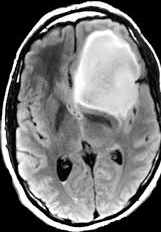

In [0]:
cv2_imshow(pos_crop_images[0])

**References**:


*   https://www.kaggle.com/ruslankl/brain-tumor-detection-v1-0-cnn-vgg-16
*   https://github.com/ruizewang/CBIR-CNN

